In [14]:
from __future__ import division, print_function
import numpy as np
from utils import divide_on_feature, train_test_split, standardize, mean_squared_error
from utils import calculate_entropy, accuracy_score, calculate_variance, Plot

In [15]:

class DecisionNode():
    """Class that represents a decision node or leaf in the decision tree

    Parameters:
    -----------
    feature_i: int
        Feature index which we want to use as the threshold measure.
    threshold: float
        The value that we will compare feature values at feature_i against to
        determine the prediction.
    value: float
        The class prediction if classification tree, or float value if regression tree.
    true_branch: DecisionNode
        Next decision node for samples where features value met the threshold.
    false_branch: DecisionNode
        Next decision node for samples where features value did not meet the threshold.
    """
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i          # Index for the feature that is tested
        self.threshold = threshold          # Threshold value for feature
        self.value = value                  # Value if the node is a leaf in the tree
        self.true_branch = true_branch      # 'Left' subtree
        self.false_branch = false_branch    # 'Right' subtree


# Super class of RegressionTree and ClassificationTree
class DecisionTree(object):
    """Super class of RegressionTree and ClassificationTree.

    Parameters:
    -----------
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_impurity: float
        The minimum impurity required to split the tree further.
    max_depth: int
        The maximum depth of a tree.
    loss: function
        Loss function that is used for Gradient Boosting models to calculate impurity.
    """
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  # Root node in dec. tree
        # Minimum n of samples to justify split
        self.min_samples_split = min_samples_split
        # The minimum impurity to justify split
        self.min_impurity = min_impurity
        # The maximum depth to grow the tree to
        self.max_depth = max_depth
        # Function to calculate impurity (classif.=>info gain, regr=>variance reduct.)
        self._impurity_calculation = None
        # Function to determine prediction of y at leaf
        self._leaf_value_calculation = None
        # If y is one-hot encoded (multi-dim) or not (one-dim)
        self.one_dim = None
        # If Gradient Boost
        self.loss = loss

    def fit(self, X, y, loss=None):
        """ Build decision tree """
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None

    def _build_tree(self, X, y, current_depth=0):
        """ Recursive method which builds out the decision tree and splits X and respective y
        on the feature of X which (based on impurity) best separates the data"""

        largest_impurity = 0
        best_criteria = None    # Feature index and threshold
        best_sets = None        # Subsets of the data

        # Check if expansion of y is needed
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        # Add y as last column of X
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # Calculate the impurity for each feature
            for feature_i in range(n_features):
                # All values of feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                # Iterate through all unique values of feature column i and
                # calculate the impurity
                for threshold in unique_values:
                    # Divide X and y depending on if the feature value of X at index feature_i
                    # meets the threshold
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Select the y-values of the two sets
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # Calculate impurity
                        impurity = self._impurity_calculation(y, y1, y2)

                        # If this threshold resulted in a higher information gain than previously
                        # recorded save the threshold value and the feature
                        # index
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],   # X of left subtree
                                "lefty": Xy1[:, n_features:],   # y of left subtree
                                "rightX": Xy2[:, :n_features],  # X of right subtree
                                "righty": Xy2[:, n_features:]   # y of right subtree
                                }

        if largest_impurity > self.min_impurity:
            # Build subtrees for the right and left branches
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                                "threshold"], true_branch=true_branch, false_branch=false_branch)

        # We're at leaf => determine value
        leaf_value = self._leaf_value_calculation(y)

        return DecisionNode(value=leaf_value)


    def predict_value(self, x, tree=None):
        """ Do a recursive search down the tree and make a prediction of the data sample by the
            value of the leaf that we end up at """

        if tree is None:
            tree = self.root

        # If we have a value (i.e we're at a leaf) => return value as the prediction
        if tree.value is not None:
            return tree.value

        # Choose the feature that we will test
        feature_value = x[tree.feature_i]

        # Determine if we will follow left or right branch
        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        # Test subtree
        return self.predict_value(x, branch)

    def predict(self, X):
        """ Classify samples one by one and return the set of labels """
        y_pred = [self.predict_value(sample) for sample in X]
        return y_pred

    def print_tree(self, tree=None, indent=" "):
        """ Recursively print the decision tree """
        if not tree:
            tree = self.root

        # If we're at leaf => print the label
        if tree.value is not None:
            print (tree.value)
        # Go deeper down the tree
        else:
            # Print test
            print ("%s:%s? " % (tree.feature_i, tree.threshold))
            # Print the true scenario
            print ("%sT->" % (indent), end="")
            self.print_tree(tree.true_branch, indent + indent)
            # Print the false scenario
            print ("%sF->" % (indent), end="")
            self.print_tree(tree.false_branch, indent + indent)

In [16]:
class RegressionTree(DecisionTree):
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        # Calculate the variance reduction
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)

        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)

class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, y1, y2):
        # Calculate information gain
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * \
            calculate_entropy(y1) - (1 - p) * \
            calculate_entropy(y2)

        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Count number of occurences of samples with label
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_information_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)


-- Classification Tree --
Accuracy: 0.9166666666666666


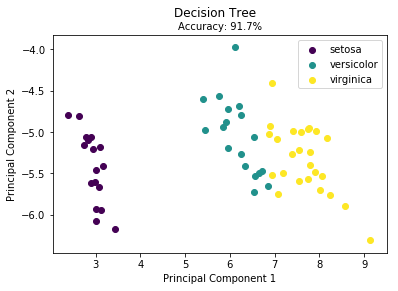

In [17]:
from sklearn import datasets
import matplotlib.pyplot as plt
import sys
import os

print ("-- Classification Tree --")

data = datasets.load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

clf = ClassificationTree()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print ("Accuracy:", accuracy)

Plot().plot_in_2d(X_test, y_pred, 
    title="Decision Tree", 
    accuracy=accuracy, 
    legend_labels=data.target_names)
